#  Gaussian SR with reference image

The following code is the official implementation of the algorithm presented in [ [ 1 ] ](#ref1). A preliminary work has been published and presented at ICASSP 2023 [ [ 2 ] ](#ref2). It performs stochastic super-resolution  with reference image of Gaussian textures.

In [37]:
import numpy as np
import os
import torch

from torchvision.transforms.functional import to_tensor, to_pil_image
from PIL import Image,ImageDraw
from IPython.display import display,HTML
import pylab as plt

from perdecomp import perdecomp_fft
import operators

# Parameters

In [2]:
#Paths to images
#Examples 'Bark','Paint','RerA','Fabric1','Wall1','Wall','Wood5','Wall_grayscale','Wall3','Fabric5','Brick','Jean','Fur'
name = 'Wall'
path_img_reference = './Data/'+name+'/Reference.png'
path_img_HR = './Data/'+name+'/HR.png'
save_to = './Results/'+name+'/'

if not os.path.exists(save_to) :
    os.makedirs(save_to)
#scale factor
r = 8

#Number of samples
Nb_samples = 6


# Observation of the HR and the reference images

Reference image


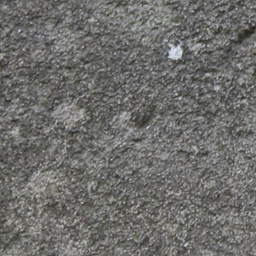

HR image


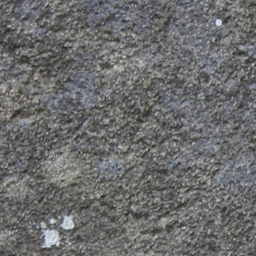

In [3]:
img_reference = to_tensor(Image.open(path_img_reference )).numpy()
nb_channels,M,N = img_reference.shape
img_HR = to_tensor(Image.open(path_img_HR )).numpy()

print('Reference image')
display(to_pil_image(torch.tensor(img_reference)))
print('HR image')
display(to_pil_image(torch.tensor(img_HR)))

# Extraction of the degradation operator

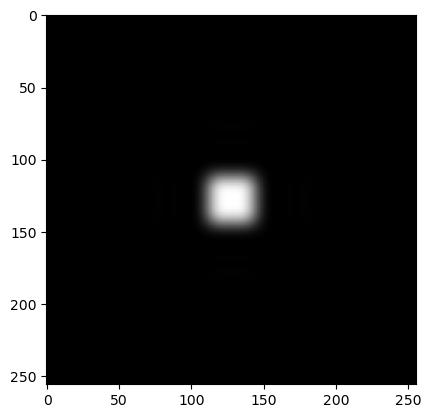

In [4]:
cfft = operators.Matlab_kernel_fft(r,nb_channels,M,N).numpy()
plt.imshow(np.fft.fftshift(np.abs(cfft[0])),cmap=plt.cm.gray)

# Observation of the LR image

LR image


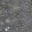

Resized LR image


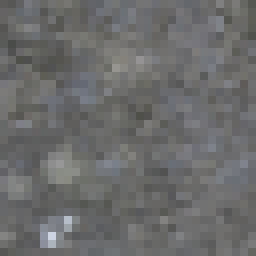

In [5]:
img_HR_fft = perdecomp_fft(torch.tensor(img_HR)).numpy()
img_LR = np.real(np.fft.ifft2(img_HR_fft*cfft))[:,::r,::r] 


m =  np.mean(img_LR,axis=(1,2))
Y = 0*img_LR.copy()
for i in range(nb_channels) :
    Y[i] = img_LR[i] - m[i]
Y_fft = np.fft.fft2(Y)
print('LR image')
pil_img_LR = to_pil_image(torch.tensor(img_LR).clip(0,1))
display(pil_img_LR)
pil_img_LR.save(save_to+'/LR.png')

print('Resized LR image')
pil_img_LR_resized = to_pil_image(torch.tensor(img_LR).clip(0,1)).resize((N,M),resample=Image.NEAREST)                   
display(pil_img_LR_resized)
pil_img_LR_resized.save(save_to+'/LR_resized.png')

# Computation of the kriging matrix

In [6]:
#Extraction of the covariance information from the reference image

m_ref = np.mean(img_reference,axis=(1,2))
t = (img_reference-m_ref.reshape(nb_channels,1,1))/np.sqrt(N*M)
t_fft = perdecomp_fft(torch.tensor(t)).numpy()

In [7]:
#Computation of the kriging kernel
cgc_fft = np.abs(cfft)**2*np.abs(t_fft)**2
cgc = np.real(np.fft.ifft2(cgc_fft))
aga = cgc[:,::r,::r]
aga_fft = np.fft.fft2(aga)

STaga = 0*cgc.copy()
STaga[:,::r,::r] += aga
STaga_fft = np.fft.fft2(STaga)

inv_diag_ST_aga_fft = 0*STaga_fft.copy()

eps=10**-16
non_zero = (STaga_fft > eps)

inv_diag_ST_aga_fft[non_zero] = 1/STaga_fft[non_zero]

lambda_fft = np.conjugate(cfft)*np.abs(t_fft)**2*inv_diag_ST_aga_fft


# Simulation

In [8]:
#Computation of the kriging component
STY = 0*img_HR
STY[:,::r,::r] += Y
STY_fft = np.fft.fft2(STY)
kriging_component = np.real(np.fft.ifft2(lambda_fft*(STY_fft)))+m.reshape(nb_channels,1,1)

#Independent sample
u_tilde_fft = t_fft*np.fft.fft2(torch.randn(Nb_samples,1,M,N))
u_tilde = np.real(np.fft.ifft2(u_tilde_fft))
Au_tilde = np.real(np.fft.ifft2(u_tilde_fft*cfft))[:,:,::r,::r]
Au_tilde_fft = np.fft.fft2(Au_tilde)


STAu_tilde = np.zeros((Nb_samples,nb_channels,M,N))
STAu_tilde[:,:,::r,::r] += np.real(np.fft.ifft2(Au_tilde_fft))
STAu_tilde_fft = np.fft.fft2(STAu_tilde)

sample = kriging_component+u_tilde-np.real(np.fft.ifft2(lambda_fft*(STAu_tilde_fft)))

Kriging component


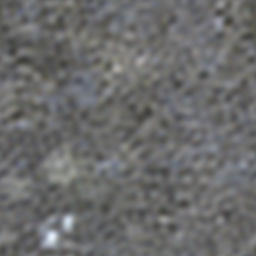

Sample 0


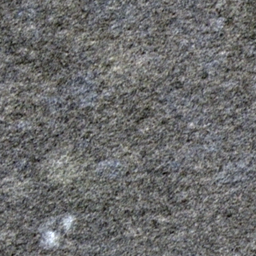

Sample 1


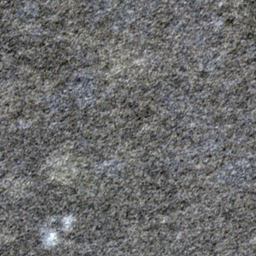

Sample 2


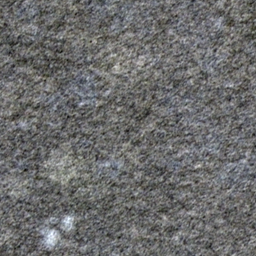

Sample 3


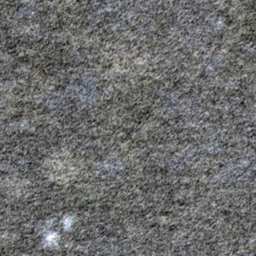

Sample 4


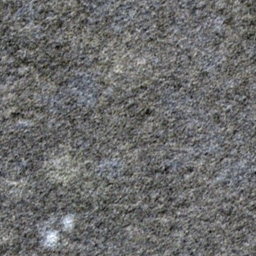

Sample 5


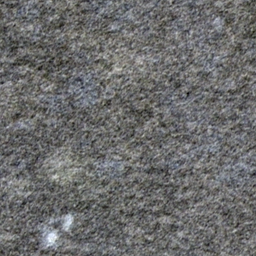

In [9]:
print('Kriging component')
pil_kriging_component = to_pil_image(torch.tensor(kriging_component).clip(0,1))
display(pil_kriging_component)
pil_kriging_component.save(save_to+'Kriging.png')
for k in range(Nb_samples) :
    print('Sample '+str(k))
    pil_sample = to_pil_image(torch.tensor(sample[k]).clip(0,1))
    display(pil_sample)
    pil_sample.save(save_to+'sample'+str(k)+'.png')

In [36]:
#Generation of a gif
frames = []
width, height = 256,256 

for i in range(Nb_samples):
    frame = to_pil_image(torch.tensor(sample[i]).clip(0,1))
    frames.append(frame)

frames[0].save(save_to+name+'_samples.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)

print('gif Path :' + save_to+name+'_samples.gif')
# You have to adapt the gif "./Results/Wall/Wall_samples.gif"

HTML(f'<img src="./Results/Wall/Wall_samples.gif" style="width:{width}px;height:{height}px;">')

gif Path :./Results/Wall/Wall_samples.gif


# References

<a id="ref1"/>

[1] [Emile Pierret, Bruno Galerne (2024). Stochastic super-Resolution for Gaussian microtextures, preprint](https://arxiv.org/abs/2405.15399)

<a id="ref2"/>

[2] [Emile Pierret, Bruno Galerne (2023). Stochastic super-Resolution for Gaussian textures, ICASSP 2023](https://arxiv.org/abs/2303.01831)